<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/plantroots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 植物の根のセグメンテーション
## ライセンス
- Yasrab, R., Atkinson, J. A., Wells, D. M., French, A. P., Pridmore, T. P., & Pound, M. P. (2019). RootNav 2.0: Deep learning for automatic navigation of complex plant root architectures. GigaScience, 8(11). https://doi.org/10.1093/gigascience/giz123
    - CC-BY-4.0
- Gaggion, N., Ariel, F., Daric, V., Lambert, É., Legendre, S., Roulé, T., Camoirano, A., Milone, D. H., Crespi, M., Blein, T., & Ferrante, E. (2021). ChronoRoot: High-throughput phenotyping by deep segmentation networks reveals novel temporal parameters of plant root system architecture. GigaScience, 10(7). https://doi.org/10.1093/gigascience/giab052
    - CC-BY-4.0
- RootNav2.0レポジトリ
    - BSD-3 Clause
- ChronoRootレポジトリ
    - GPLv3
- 本ノートブック
    - GPLv3

## 解説
根の形態や構造を理解することは、植物科学や農業にとって非常に重要です。しかし、根は土中に隠れているため、その構造を解析することは困難でした。近年、画像処理技術の発展により、根の構造をより詳細に解析できるようになってきました。本ノートブックでは、Yasrabら(2019)によって提案されたRootNav2.0と、Gaggionら（2021）らによって提案されたChronoRootの２手法の紹介をします。

### RootNav2.0
「RootNav 2.0」は、畳み込みニューラルネットワーク（CNN）をベースとしており、以下の特徴を持っています。

- CNNはマルチタスク学習を行い、主根・側根のセマンティックセグメンテーションと、根の先端や種子の位置をキーポイント座標の推定を同時に行う。
- コムギ、シロイヌナズナ、セイヨウアブラナの根で学習。
- セグメンテーション結果にはConditional Rando Field(CRF)を適用し、根の分離性能を向上。
- 検出された根の先端と種子の位置を基に、A*アルゴリズム（最短経路探索）を用いて根の構造を抽出。

RootNav 2.0では、第1次根と第2次根に対して別々にグラフを構築し、探索を行います。これにより、複雑に絡み合った根の構造を、種子から根の先端に向かって順に追跡することができます。得られた根の経路は、スプライン曲線で滑らかに補間され、最終的にRSML(Root System Markup Language)形式で出力されます。

### ChronoRoot
「ChronoRoot」もRootNav2.0と同様にCNNベースの根定量モデルであり、以下の特徴を持っています。

- （主根・側根を区別しない）根のセマンティックセグメンテーション
- シロイヌナズナの根で学習
- 後処理にCRFの採用
- 同個体を撮影した時系列データの推論結果を利用し、加重移動平均によって推論結果を安定化。
- Skeletonizationを経由し深さ優先探索アルゴリズムによってグラフ構造を構築。

ChronoRootは時間情報を積極的に利用し、根の成長動態を詳細に解析することに特化しているのに対し、RootNav 2.0は個々の画像から根の構造を高精度に抽出することに重点を置いているといえます。


**ノートブックでは推論コードの紹介を中心とします。一部の後処理の実行・解説は行いません（Colaboratoryでの一部ライブラリ非対応・GUI機能非対応など）。興味のある方はそれぞれの公式レポジトリからソースコードを見て参考にしてください。**

# RootNav2.0

## 環境設定

In [ ]:
!mkdir rootnav2
!mkdir rootnav2/dataset

公式レポジトリをもとにして、Google Colaboratoryで動作するフォークを作成しましたのでそちらを使用します。公式レポジトリは２０２４年4月時点で更新が続けられているため、このような対応は近い将来必要なくなるかもしれません。ライセンスはフォーク元に準拠します。

In [ ]:
#!cd rootnav2 && git clone https://github.com/robail-yasrab/RootNav-2.0/tree/master?tab=readme-ov-file
!cd rootnav2 && git clone https://github.com/totti0223/RootNav-2.0-colab-compatible.git
!cd rootnav2/RootNav-2.0-colab-compatible/inference && pip install -r requirements.txt

In [13]:
import os
import matplotlib.pyplot as plt
import cv2

データセットのダウンロード

In [12]:
# データセットのダウンロード
# cf. http://gigadb.org/dataset/100651

%cd rootnav2/dataset
!wget  -c ftp://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100651/datasets/arabidopsis-dataset.zip
!unzip arabidopsis-dataset.zip
!wget -c ftp://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100651/datasets/rapeseed-dataset.zip
!unzip rapeseed-dataset.zip
!wget -c ftp://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100651/datasets/wheat-dataset.zip
!unzip -q wheat-dataset.zip
%cd /content
# モデルファイルは続くinferenceで自動的にダウンロードされます。

/content


## 画像の確認
RootNav2.0ではArabidopsis, Rapeseed, Wheatのデータセットが用意されており、それぞれに対応するモデルが提供されています。それぞれのデータセットから画像を１枚ずつ表示してみましょう。

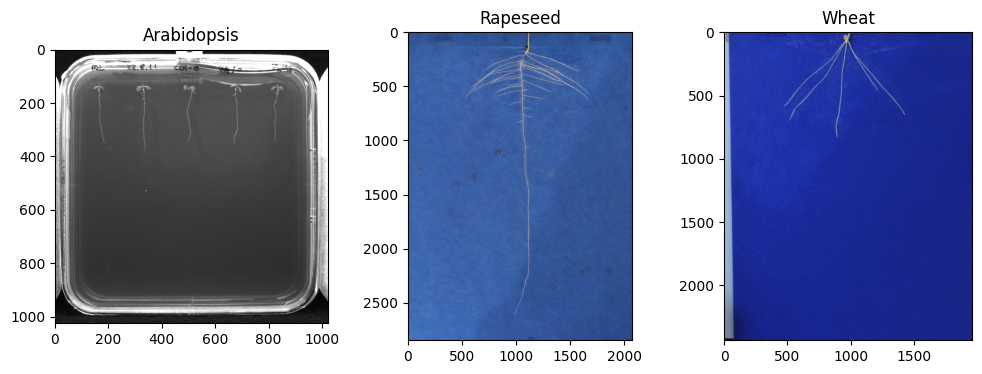

In [17]:
datasetdir = "rootnav2/dataset"
datasets = ["Arabidopsis/test","Rapeseed/test", "Wheat/Test"]

plt.figure(figsize=(12,4))
for i, dataset in enumerate(datasets):
    files = os.listdir(os.path.join(datasetdir, dataset))
    file = files[0]
    image = cv2.imread(os.path.join(datasetdir, dataset, file))[...,::-1]
    plt.subplot(1,3,i+1)
    plt.title(dataset.split("/")[0])
    plt.imshow(image)


## 推論
RootNav2.0ではrootnav.pyに必要なargumentを添えて実行すればモデルのダウンロードから推論までend2endで行うことができます。

まずは、結果格納用のサブディレクトリを作成します。

In [19]:
%cd /content
!mkdir rootnav2/results
for specie in ["Rapeseed", "Arabidopsis", "Wheat"]:
    !mkdir {os.path.join("rootnav2", "results", specie)}

/content


推論します。モデルファイルは推論時に自動的にダウンロードされます。

In [26]:
%cd /content/rootnav2/RootNav-2.0-colab-compatible/inference

!python rootnav.py --model osr_bluepaper ../../dataset/Rapeseed/test ../../results/Rapeseed
!python rootnav.py --model wheat_bluepaper ../../dataset/Wheat/Test ../../results/Wheat
!python rootnav.py --model arabidopsis_plate ../../dataset/Arabidopsis/test ../../results/Arabidopsis

%cd /content/rootnav2

/content/rootnav2/RootNav-2.0-colab-compatible/inference
RootNav 2.1
Loading model...Done
Now processing 19-09-13_TC_0101_RUN13_R2-T3-C3-P22-S1.JPG
RSML and mask for 1 plant output saved in: ../../results/Rapeseed
Time elapsed: 4.90s

Now processing 19-09-13_TC_00R3_RUN13_R2-T1-C2-P20-S1.JPG
RSML and mask for 1 plant output saved in: ../../results/Rapeseed
Time elapsed: 1.07s

Now processing 19-09-13_TC_00R2_RUN13_R2-T2-C3-P07-S2.JPG
[05:06:02.756] WARNING: No seed locations found - no output
Now processing 19-09-13_TC_0101_RUN13_R2-T2-C3-P14-S1.JPG
RSML and mask for 1 plant output saved in: ../../results/Rapeseed
Time elapsed: 1.68s

Now processing 19-09-13_TC_0102_RUN13_R2-T4-C3-P08-S1.JPG
[05:06:04.674] WARNING: No seed locations found - no output
Now processing 19-09-13_TC_0102_RUN13_R2-T1-C2-P29-S1.JPG
RSML and mask for 1 plant output saved in: ../../results/Rapeseed
Time elapsed: 1.65s

Now processing 19-09-13_TC_0104_RUN13_R2-T2-C1-P15-S1.JPG
[05:06:06.580] WARNING: No seed loca

結果を見てみましょう。

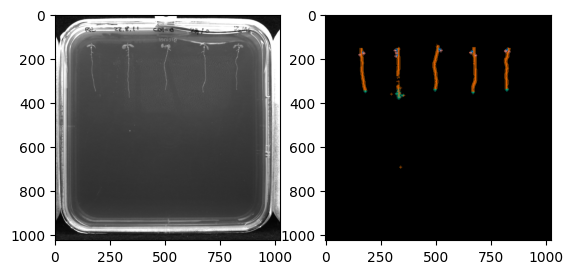

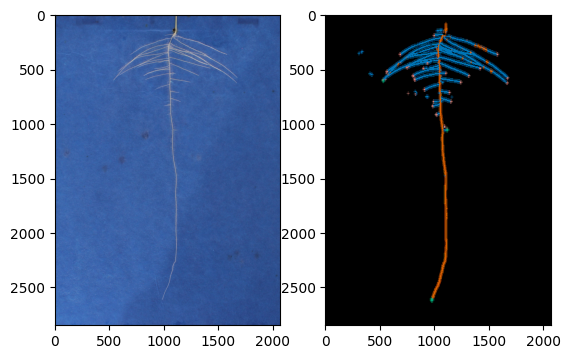

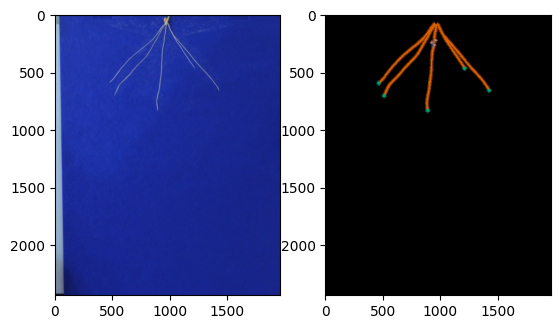

In [27]:
indirs = ["dataset/Arabidopsis/test","dataset/Rapeseed/test", "dataset/Wheat/Test"]
outdirs = ["results/Arabidopsis","results/Rapeseed", "results/Wheat"]
for indir, outdir in zip(indirs, outdirs):
    files = os.listdir(indir)
    for file in files:
        image = cv2.imread(os.path.join(indir, file))[...,::-1]
        res_files = os.listdir(outdir)
        base = os.path.splitext(file)[0]
        res_file = [x for x in res_files if x.startswith(base) and not x.endswith("rsml")][0]
        res = cv2.imread(os.path.join(outdir, res_file))[...,::-1]

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(res)
        plt.show()
        break

### Root System Markup Language (RSML)経由での表現型抽出

Root System Markup Language（RSML）は、根のアーキテクチャデータを表現するxml型のファイル形式です。この形式では、2次元または3次元の画像メタデータ、植物と根の特性や形状、個々の根の経路に沿った連続関数、および複数の時間点での画像、植物、根のスケールでのアノテーションを保存できます。RootNav2.0は推論時にRSML形式でデータを出力します。必要に応じてここから表現型を抽出しましょう。

なお、RSML公式のライブラリはColaboratory非対応なのでこの環境で解析する以上、手動でプログラムコードを書く必要があることに注意が必要です。

In [31]:
# 中身を出力するためのコードを記します。
import xml.etree.ElementTree as ET

path = "/content/rootnav2/results/Arabidopsis/RN2,0,20,testset.rsml"

doc = ET.parse(path)
root = doc.getroot()
ET.dump(root)

<rsml>
  <metadata>
    <version>1</version>
    <unit>pixel</unit>
    <resolution>1</resolution>
    <last-modified>1</last-modified>
    <software>ROOT_NAV.2.0</software>
    <user>Robi</user>
    <file-key>RN2,0,20,testset</file-key>
  </metadata>
  <scene>
    <plant id="1" label="wheat_bluepaper">
      <root id="1" label="primary" poaccession="1">
        <geometry>
          <polyline>
            <point x="530.0" y="124.0" />
            <point x="530.2406651752309" y="124.96541046999411" />
            <point x="530.4878184888353" y="125.92918441797269" />
            <point x="530.7378132066451" y="126.89222583005444" />
            <point x="530.9892149619279" y="127.85490103139674" />
            <point x="531.2412815821051" y="128.81740239780672" />
            <point x="531.4935536160896" y="129.77984995406212" />
            <point x="531.7457017695356" y="130.74232996932383" />
            <point x="531.9974786870171" y="131.70490715503226" />
            <point x="532

# ChronoRoot

別ライブラリをインストール、インポートしますので、colaboratoryのメニューから「ランタイム→セッションを再起動する」を選択してリセットしておきましょう。

## 環境設定

RootNav2.0と同様にディレクトリの作成を含む環境設定を行います。

In [ ]:
%cd /content
!mkdir chronoroot
!mkdir chronoroot/dataset
!mkdir chronoroot/results

In [33]:
!pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


ChronoRootを部分的にColaboratoryで動かすためのフォークを作成してありますので、こちらをダウンロードします。

In [36]:
!cd chronoroot && git clone https://github.com/totti0223/ChronoRoot-colab-compatible.git

Cloning into 'ChronoRoot-colab-compatible'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 115 (delta 62), reused 91 (delta 40), pack-reused 0
Receiving objects: 100% (115/115), 2.81 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (62/62), done.


データセットのダウンロードをします。

In [ ]:
!cd chronoroot/dataset && wget -O dataset.zip https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100911/LabeledDataset/Test_ChronoRoot.zip
!cd chronoroot/dataset && unzip dataset.zip

データセットの確認をしてみましょう。

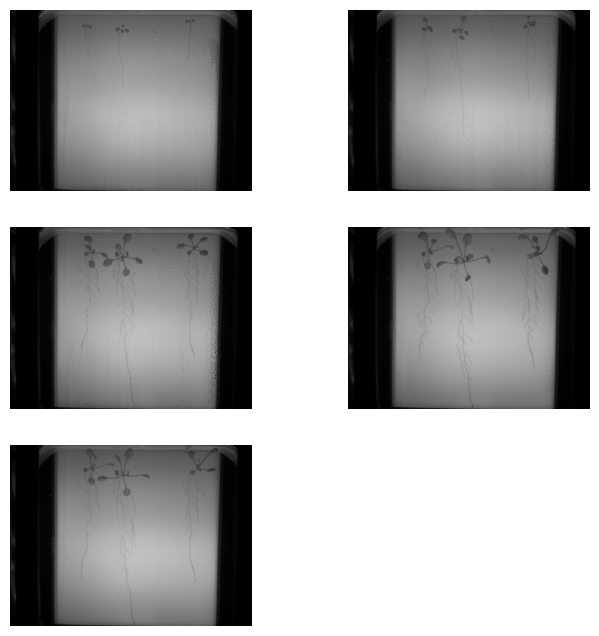

In [61]:
import matplotlib.pyplot as plt
import cv2
import os

DATASET_SUB_DIR = "/content/chronoroot/dataset/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

files = os.listdir(DATASET_SUB_DIR)
files = [x for x in files if x.endswith(".png")]
plt.figure(figsize=(8,8))
for i, file in enumerate(files):
    plt.subplot(3,2,i+1)
    path = os.path.join(DATASET_SUB_DIR, file)
    image = cv2.imread(path)
    plt.imshow(image)
    plt.axis("off")
plt.subplots_adjust()

## 推論

In [47]:
!cd chronoroot/ChronoRoot-colab-compatible && \
python segmentFast_colab.py /content/chronoroot/dataset/Test_ChronoRoot/rpi14_2019-12-09_16-13/1 \
--output_dir /content/chronoroot/results \
--use_crf

2024-04-27 06:29:58.348378: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 06:29:58.369732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 06:29:58.369768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 06:29:58.370446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 06:29:58.373917: I tensorflow/core/platform/cpu_feature_guar

## 結果確認

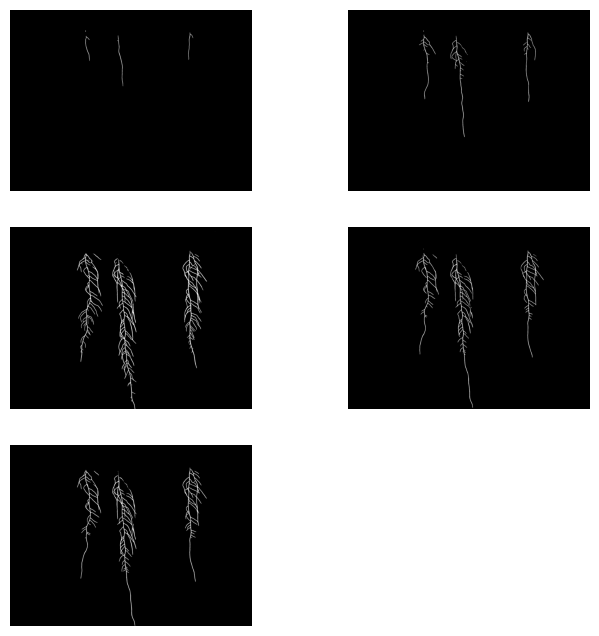

In [58]:
%cd /content
RESULT_DIR = "/content/chronoroot/results"

files = os.listdir(RESULT_DIR)
plt.figure(figsize=(8,8))
for i, file in enumerate(files):
    plt.subplot(3,2,i+1)
    path = os.path.join(RESULT_DIR, file)
    image = cv2.imread(path)
    plt.imshow(image)
    plt.axis("off")
plt.subplots_adjust()

このあと公式レポジトリではchronoRoot.pyを使って個別の根の主根・側根識別や根の経路の抽出を行いますが、種子の座標やboundingboxの定義はGUIで行う必要がある一方、ColaboratoryではGUI機能が使えないため、ここでは推論結果の確認までとします。

## 最後に
根のセグメンテーションは、COCOデータセットで扱うような物体と違い、領域が極めて狭く、また細いという特徴があります。そのため、今回紹介した論文中でも多様な訓練テクニックを活用しています。本ノートブックでは紹介しませんが、ぜひ論文をあたって、その詳細を学んでみてください。